# Intrusion detection on NSL-KDD

This is my try with [NSL-KDD](http://www.unb.ca/research/iscx/dataset/iscx-NSL-KDD-dataset.html) dataset, which is an improved version of well-known [KDD'99](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html) dataset. I've used Python, Scikit-learn and PySpark via [ready-to-run Jupyter applications in Docker](https://github.com/jupyter/docker-stacks).

I've tried a variety of approaches to deal with this dataset. Here are presented some of them.

To be able to run this notebook, use `make nsl-kdd-pyspark` command. It'll download the latest jupyter/pyspark-notebook docker image and start a container with Jupyter available at `8889` port.

## Contents

1. [Task description summary](#1.-Task-description-summary)
2. [Data loading](#2.-Data-loading)
3. [Exploratory Data Analysis](#3.-Exploratory-Data-Analysis)
4. [One Hot Encoding for categorical variables](#4.-One-Hot-Encoding-for-categorical-variables)
5. [Feature Selection using Attribute Ratio](#5.-Feature-Selection-using-Attribute-Ratio)
6. [Data preparation](#6.-Data-preparation)
7. [Visualization via PCA](#7.-Visualization-via-PCA)
8. [KMeans clustering with Random Forest Classifiers](#8.-KMeans-clustering-with-Random-Forest-Classifiers)
9. [Gaussian Mixture clustering with Random Forest Classifiers](#9.-Gaussian-Mixture-clustering-with-Random-Forest-Classifiers)
10. [Supervised approach for dettecting each type of attacks separately](#10.-Supervised-approach-for-dettecting-each-type-of-attacks-separately)
11. [Ensembling experiments](#11.-Ensembling-experiments)
12. [Results summary](#12.-Results-summary)

## 1. Task description summary

Software to detect network intrusions protects a computer network from unauthorized users, including perhaps insiders. The intrusion detector learning task is to build a predictive model (i.e. a classifier) capable of distinguishing between bad connections, called intrusions or attacks, and good normal connections.

A connection is a sequence of TCP packets starting and ending at some well defined times, between which data flows to and from a source IP address to a target IP address under some well defined protocol. Each connection is labeled as either normal, or as an attack, with exactly one specific attack type. Each connection record consists of about 100 bytes.

Attacks fall into four main categories:

- DOS: denial-of-service, e.g. syn flood;
- R2L: unauthorized access from a remote machine, e.g. guessing password;
- U2R: unauthorized access to local superuser (root) privileges, e.g., various ''buffer overflow'' attacks;
- probing: surveillance and other probing, e.g., port scanning.

It is important to note that the test data is not from the same probability distribution as the training data, and it includes specific attack types not in the training data. This makes the task more realistic. Some intrusion experts believe that most novel attacks are variants of known attacks and the "signature" of known attacks can be sufficient to catch novel variants.  The datasets contain a total of 24 training attack types, with an additional 14 types in the test data only.

The complete task description could be found [here](http://kdd.ics.uci.edu/databases/kddcup99/task.html).

### NSL-KDD dataset description

[NSL-KDD](http://www.unb.ca/research/iscx/dataset/iscx-NSL-KDD-dataset.html) is a data set suggested to solve some of the inherent problems of the [KDD'99](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html) data set.

The NSL-KDD data set has the following advantages over the original KDD data set:
- It does not include redundant records in the train set, so the classifiers will not be biased towards more frequent records.
- There is no duplicate records in the proposed test sets; therefore, the performance of the learners are not biased by the methods which have better detection rates on the frequent records.
- The number of selected records from each difficultylevel group is inversely proportional to the percentage of records in the original KDD data set. As a result, the classification rates of distinct machine learning methods vary in a wider range, which makes it more efficient to have an accurate evaluation of different learning techniques.
- The number of records in the train and test sets are reasonable, which makes it affordable to run the experiments on the complete set without the need to randomly select a small portion. Consequently, evaluation results of different research works will be consistent and comparable.

## 2. Data loading

In [1]:
# Here are some imports that are used along this notebook
import os
import math
import itertools
import multiprocessing
import pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from collections import OrderedDict
%matplotlib inline
gt0 = time()

In [2]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext, Row

In [3]:
conf = SparkConf()\
    .setMaster(f"local[{multiprocessing.cpu_count()}]")\
    .setAppName("PySpark NSL-KDD")\
    .setAll([("spark.driver.memory", "8g"), ("spark.default.parallelism", f"{multiprocessing.cpu_count()}")])

# Creating local SparkContext with specified SparkConf and creating SQLContext based on it
sc = SparkContext.getOrCreate(conf=conf)
sc.setLogLevel('INFO')
sqlContext = SQLContext(sc)

In [4]:
from pyspark.sql.types import *
from pyspark.sql.functions import udf, split, col
import pyspark.sql.functions as sql

train20_nsl_kdd_dataset_path = os.path.join("NSL_KDD_Dataset", "KDDTrain+_20Percent.txt")
train_nsl_kdd_dataset_path = os.path.join("NSL_KDD_Dataset", "KDDTrain+.txt")
test_nsl_kdd_dataset_path = os.path.join("NSL_KDD_Dataset", "KDDTest+.txt")

col_names = np.array(["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","labels"])

nominal_inx = [1, 2, 3]
binary_inx = [6, 11, 13, 14, 20, 21]
numeric_inx = list(set(range(41)).difference(nominal_inx).difference(binary_inx))

nominal_cols = col_names[nominal_inx].tolist()
binary_cols = col_names[binary_inx].tolist()
numeric_cols = col_names[numeric_inx].tolist()

In [5]:
# Function to load dataset and divide it into 8 partitions
def load_dataset(path):
    dataset_rdd = sc.textFile(path, 8).map(lambda line: line.split(','))
    dataset_df = (dataset_rdd.toDF(col_names.tolist()).select(
                    col('duration').cast(DoubleType()),
                    col('protocol_type').cast(StringType()),
                    col('service').cast(StringType()),
                    col('flag').cast(StringType()),
                    col('src_bytes').cast(DoubleType()),
                    col('dst_bytes').cast(DoubleType()),
                    col('land').cast(DoubleType()),
                    col('wrong_fragment').cast(DoubleType()),
                    col('urgent').cast(DoubleType()),
                    col('hot').cast(DoubleType()),
                    col('num_failed_logins').cast(DoubleType()),
                    col('logged_in').cast(DoubleType()),
                    col('num_compromised').cast(DoubleType()),
                    col('root_shell').cast(DoubleType()),
                    col('su_attempted').cast(DoubleType()),
                    col('num_root').cast(DoubleType()),
                    col('num_file_creations').cast(DoubleType()),
                    col('num_shells').cast(DoubleType()),
                    col('num_access_files').cast(DoubleType()),
                    col('num_outbound_cmds').cast(DoubleType()),
                    col('is_host_login').cast(DoubleType()),
                    col('is_guest_login').cast(DoubleType()),
                    col('count').cast(DoubleType()),
                    col('srv_count').cast(DoubleType()),
                    col('serror_rate').cast(DoubleType()),
                    col('srv_serror_rate').cast(DoubleType()),
                    col('rerror_rate').cast(DoubleType()),
                    col('srv_rerror_rate').cast(DoubleType()),
                    col('same_srv_rate').cast(DoubleType()),
                    col('diff_srv_rate').cast(DoubleType()),
                    col('srv_diff_host_rate').cast(DoubleType()),
                    col('dst_host_count').cast(DoubleType()),
                    col('dst_host_srv_count').cast(DoubleType()),
                    col('dst_host_same_srv_rate').cast(DoubleType()),
                    col('dst_host_diff_srv_rate').cast(DoubleType()),
                    col('dst_host_same_src_port_rate').cast(DoubleType()),
                    col('dst_host_srv_diff_host_rate').cast(DoubleType()),
                    col('dst_host_serror_rate').cast(DoubleType()),
                    col('dst_host_srv_serror_rate').cast(DoubleType()),
                    col('dst_host_rerror_rate').cast(DoubleType()),
                    col('dst_host_srv_rerror_rate').cast(DoubleType()),
                    col('labels').cast(StringType())))

    return dataset_df

The first part of data preparation is deviding connections into normal and attack classes based on 'labels' column. Then attacks are splitted to four main categories: DoS, Probe, R2L and U2R. After this, all of those categories are indexed. Also, ID column is added to simplify work with clustered data.

In [6]:
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.feature import StringIndexer
from pyspark import keyword_only
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param

# Dictionary that contains mapping of various attacks to the four main categories
attack_dict = {
    'normal': 'normal',
    
    'back': 'DoS',
    'land': 'DoS',
    'neptune': 'DoS',
    'pod': 'DoS',
    'smurf': 'DoS',
    'teardrop': 'DoS',
    'mailbomb': 'DoS',
    'apache2': 'DoS',
    'processtable': 'DoS',
    'udpstorm': 'DoS',
    
    'ipsweep': 'Probe',
    'nmap': 'Probe',
    'portsweep': 'Probe',
    'satan': 'Probe',
    'mscan': 'Probe',
    'saint': 'Probe',

    'ftp_write': 'R2L',
    'guess_passwd': 'R2L',
    'imap': 'R2L',
    'multihop': 'R2L',
    'phf': 'R2L',
    'spy': 'R2L',
    'warezclient': 'R2L',
    'warezmaster': 'R2L',
    'sendmail': 'R2L',
    'named': 'R2L',
    'snmpgetattack': 'R2L',
    'snmpguess': 'R2L',
    'xlock': 'R2L',
    'xsnoop': 'R2L',
    'worm': 'R2L',
    
    'buffer_overflow': 'U2R',
    'loadmodule': 'U2R',
    'perl': 'U2R',
    'rootkit': 'U2R',
    'httptunnel': 'U2R',
    'ps': 'U2R',    
    'sqlattack': 'U2R',
    'xterm': 'U2R'
}

attack_mapping_udf = udf(lambda v: attack_dict[v])

class Labels2Converter(Transformer):

    @keyword_only
    def __init__(self):
        super(Labels2Converter, self).__init__()

    def _transform(self, dataset):
        return dataset.withColumn('labels2', sql.regexp_replace(col('labels'), '^(?!normal).*$', 'attack'))
     
class Labels5Converter(Transformer):
    
    @keyword_only
    def __init__(self):
        super(Labels5Converter, self).__init__()

    def _transform(self, dataset):
        return dataset.withColumn('labels5', attack_mapping_udf(col('labels')))
    
labels2_indexer = StringIndexer(inputCol="labels2", outputCol="labels2_index")
labels5_indexer = StringIndexer(inputCol="labels5", outputCol="labels5_index")

labels_mapping_pipeline = Pipeline(stages=[Labels2Converter(), Labels5Converter(), labels2_indexer, labels5_indexer])

labels2 = ['normal', 'attack']
labels5 = ['normal', 'DoS', 'Probe', 'R2L', 'U2R']
labels_col = 'labels2_index'

In [7]:
# Loading train data
t0 = time()
train_df = load_dataset(train_nsl_kdd_dataset_path)

# Fitting preparation pipeline
labels_mapping_model = labels_mapping_pipeline.fit(train_df)

# Transforming labels column and adding id column
train_df = labels_mapping_model.transform(train_df).withColumn('id', sql.monotonically_increasing_id())

train_df = train_df.cache()
print(f"Number of examples in train set: {train_df.count()}")
print(f"Time: {time() - t0:.2f}s")

Number of examples in train set: 125973
Time: 12.46s


In [8]:
# Loading test data
t0 = time()
test_df = load_dataset(test_nsl_kdd_dataset_path)

# Transforming labels column and adding id column
test_df = labels_mapping_model.transform(test_df).withColumn('id', sql.monotonically_increasing_id())

test_df = test_df.cache()
print(f"Number of examples in test set: {test_df.count()}")
print(f"Time: {time() - t0:.2f}s")

Number of examples in test set: 22544
Time: 1.29s


## 2. Exploratory Data Analysis

Here are some descriptive statistics of available features.

In [9]:
# Labels columns
(train_df.groupby('labels2').count().show())
(train_df.groupby('labels5').count().sort(sql.desc('count')).show())

+-------+-----+
|labels2|count|
+-------+-----+
| normal|67343|
| attack|58630|
+-------+-----+

+-------+-----+
|labels5|count|
+-------+-----+
| normal|67343|
|    DoS|45927|
|  Probe|11656|
|    R2L|  995|
|    U2R|   52|
+-------+-----+



In [10]:
(test_df.groupby('labels2').count().show())
(test_df.groupby('labels5').count().sort(sql.desc('count')).show())

+-------+-----+
|labels2|count|
+-------+-----+
| normal| 9711|
| attack|12833|
+-------+-----+

+-------+-----+
|labels5|count|
+-------+-----+
| normal| 9711|
|    DoS| 7458|
|    R2L| 2754|
|  Probe| 2421|
|    U2R|  200|
+-------+-----+



In [11]:
# 'protocol_type' nominal column
(train_df.crosstab(nominal_cols[0], 'labels2').sort(sql.asc(nominal_cols[0] + '_labels2')).show())
(train_df.crosstab(nominal_cols[0], 'labels5').sort(sql.asc(nominal_cols[0] + '_labels5')).show())

+---------------------+------+------+
|protocol_type_labels2|attack|normal|
+---------------------+------+------+
|                 icmp|  6982|  1309|
|                  tcp| 49089| 53600|
|                  udp|  2559| 12434|
+---------------------+------+------+

+---------------------+-----+-----+---+---+------+
|protocol_type_labels5|  DoS|Probe|R2L|U2R|normal|
+---------------------+-----+-----+---+---+------+
|                 icmp| 2847| 4135|  0|  0|  1309|
|                  tcp|42188| 5857|995| 49| 53600|
|                  udp|  892| 1664|  0|  3| 12434|
+---------------------+-----+-----+---+---+------+



In [12]:
# 'service' nominal column
print(train_df.select(nominal_cols[1]).distinct().count())
(train_df.crosstab(nominal_cols[1], 'labels2').sort(sql.asc(nominal_cols[1] + '_labels2')).show(n=70))
(train_df.crosstab(nominal_cols[1], 'labels5').sort(sql.asc(nominal_cols[1] + '_labels5')).show(n=70))

70
+---------------+------+------+
|service_labels2|attack|normal|
+---------------+------+------+
|            IRC|     1|   186|
|            X11|     6|    67|
|         Z39_50|   862|     0|
|            aol|     2|     0|
|           auth|   719|   236|
|            bgp|   710|     0|
|        courier|   734|     0|
|       csnet_ns|   545|     0|
|            ctf|   563|     0|
|        daytime|   521|     0|
|        discard|   538|     0|
|         domain|   531|    38|
|       domain_u|     9|  9034|
|           echo|   434|     0|
|          eco_i|  4089|   497|
|          ecr_i|  2887|   190|
|            efs|   485|     0|
|           exec|   474|     0|
|         finger|  1222|   545|
|            ftp|   836|   918|
|       ftp_data|  1876|  4984|
|         gopher|   518|     0|
|        harvest|     2|     0|
|      hostnames|   460|     0|
|           http|  2289| 38049|
|      http_2784|     1|     0|
|       http_443|   530|     0|
|      http_8001|     2|     0|
|    

In [13]:
# 'flag' nominal column
print(train_df.select(nominal_cols[2]).distinct().count())
(train_df.crosstab(nominal_cols[2], 'labels2').sort(sql.asc(nominal_cols[2] + '_labels2')).show())
(train_df.crosstab(nominal_cols[2], 'labels5').sort(sql.asc(nominal_cols[2] + '_labels5')).show())

11
+------------+------+------+
|flag_labels2|attack|normal|
+------------+------+------+
|         OTH|    35|    11|
|         REJ|  8540|  2693|
|        RSTO|  1343|   219|
|      RSTOS0|   103|     0|
|        RSTR|  2275|   146|
|          S0| 34497|   354|
|          S1|     4|   361|
|          S2|     8|   119|
|          S3|     4|    45|
|          SF| 11552| 63393|
|          SH|   269|     2|
+------------+------+------+

+------------+-----+-----+---+---+------+
|flag_labels5|  DoS|Probe|R2L|U2R|normal|
+------------+-----+-----+---+---+------+
|         OTH|    0|   35|  0|  0|    11|
|         REJ| 5671| 2869|  0|  0|  2693|
|        RSTO| 1216|   80| 46|  1|   219|
|      RSTOS0|    0|  103|  0|  0|     0|
|        RSTR|   90| 2180|  5|  0|   146|
|          S0|34344|  153|  0|  0|   354|
|          S1|    2|    1|  1|  0|   361|
|          S2|    5|    2|  1|  0|   119|
|          S3|    0|    1|  3|  0|    45|
|          SF| 4599| 5967|935| 51| 63393|
|          SH| 

In [14]:
# Binary columns
(train_df.select(binary_cols).describe().toPandas().transpose())

,0,1,2,3,4
summary,count,mean,stddev,min,max
land,125973,1.9845522453224102E-4,0.014086071671513094,0.0,1.0
logged_in,125973,0.3957355941352512,0.48901005300524175,0.0,1.0
root_shell,125973,0.0013415573178379495,0.03660284383979861,0.0,1.0
su_attempted,125973,0.0011034110483992602,0.04515438381386557,0.0,2.0
is_host_login,125973,7.938208981289641E-6,0.0028174827384191085,0.0,1.0
is_guest_login,125973,0.009422654060790804,0.09661232709143104,0.0,1.0


In [15]:
# 'su_attempted' should be a binary feature, but has 3 values
(train_df.crosstab('su_attempted', 'labels2').show())

+--------------------+------+------+
|su_attempted_labels2|attack|normal|
+--------------------+------+------+
|                 2.0|     0|    59|
|                 1.0|     1|    20|
|                 0.0| 58629| 67264|
+--------------------+------+------+



In [16]:
# '2.0' value is replaced to '0.0' for both train and test datasets
train_df = train_df.replace(2.0, 0.0, 'su_attempted')
test_df = test_df.replace(2.0, 0.0, 'su_attempted')

In [17]:
# Numeric columns
print(len(numeric_cols))
(train_df.select(numeric_cols).describe().toPandas().transpose())

32


,0,1,2,3,4
summary,count,mean,stddev,min,max
duration,125973,287.1446500440571,2604.515309867592,0.0,42908.0
src_bytes,125973,45566.74300048423,5870331.181893551,0.0,1.379963888E9
dst_bytes,125973,19779.114421344257,4021269.1514414474,0.0,1.309937401E9
wrong_fragment,125973,0.022687401268525795,0.25352998595201254,0.0,3.0
urgent,125973,1.1113492573805498E-4,0.014366026620154243,0.0,3.0
hot,125973,0.20440888126820828,2.1499684337047587,0.0,77.0
num_failed_logins,125973,0.0012224841831186047,0.045239138981329835,0.0,5.0
num_compromised,125973,0.279250315543807,23.942042242795125,0.0,7479.0
num_root,125973,0.30219173949973405,24.3996180888374,0.0,7468.0


In [18]:
(train_df.crosstab('num_outbound_cmds', 'labels2').show())

+-------------------------+------+------+
|num_outbound_cmds_labels2|attack|normal|
+-------------------------+------+------+
|                      0.0| 58630| 67343|
+-------------------------+------+------+



As 'num_outbound_cmds' feature takes only 0.0 values, so it is dropped as redundant.

In [19]:
train_df = train_df.drop('num_outbound_cmds')
test_df = test_df.drop('num_outbound_cmds')
numeric_cols.remove('num_outbound_cmds')

Commented code below is related to removing highly correlated features. However, it hasen't been tested a lot yet.

In [20]:
# from pyspark.mllib.stat import Statistics
# from pyspark.mllib.linalg import Vectors
# from pyspark.ml.feature import VectorAssembler

# t0 = time()
# stat_assembler = VectorAssembler(
#                 inputCols=numeric_cols,
#                 outputCol='features')

# stat_rdd = stat_assembler.transform(train_df).rdd.map(lambda row: row['features'].toArray())

# pearson_corr = Statistics.corr(stat_rdd, method='pearson')
# spearman_corr = Statistics.corr(stat_rdd, method='spearman')

# print(time() - t0)

In [21]:
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# ax1.set_title("Pearson")
# ax2.set_title("Spearman")
# sns.heatmap(pearson_corr, ax=ax1)
# sns.heatmap(spearman_corr, ax=ax2)

In [22]:
# inx_correlated_to_delete = [8, 15, 28, 17, 29]

# for inx in inx_correlated_to_delete:
#     train_df = train_df.drop(numeric_cols[inx])
#     test_df = test_df.drop(numeric_cols[inx])

# numeric_cols = [col for inx, col in enumerate(numeric_cols) if inx not in inx_correlated_to_delete]

# train_df = train_df.cache()
# test_df = test_df.cache()
# print(train_df.count())
# print(test_df.count())
# print(len(numeric_cols))

## 4. One Hot Encoding for categorical variables

One Hot Encoding (OHE) is used for treating categorical variables. Custom function is created for demonstration purposes. However, it could be easily replaced by PySpark OneHotEncoder.

In [23]:
def ohe_vec(cat_dict, row):
    vec = np.zeros(len(cat_dict))
    vec[cat_dict[row]] = float(1.0)
    return vec.tolist()

def ohe(df, nominal_col):
    categories = (df.select(nominal_col)
                    .distinct()
                    .rdd.map(lambda row: row[0])
                    .collect())
    
    cat_dict = dict(zip(categories, range(len(categories))))
    
    udf_ohe_vec = udf(lambda row: ohe_vec(cat_dict, row), 
                      StructType([StructField(cat, DoubleType(), False) for cat in categories]))
    
    df = df.withColumn(nominal_col + '_ohe', udf_ohe_vec(col(nominal_col))).cache()
    
    nested_cols = [nominal_col + '_ohe.' + cat for cat in categories]
    ohe_cols = [nominal_col + '_' + cat for cat in categories]
        
    for new, old in zip(ohe_cols, nested_cols):
        df = df.withColumn(new, col(old))

    df = df.drop(nominal_col + '_ohe')
                   
    return df, ohe_cols

In [24]:
t0 = time()
train_ohe_cols = []

train_df, train_ohe_col0 = ohe(train_df, nominal_cols[0])
train_ohe_cols += train_ohe_col0

train_df, train_ohe_col1 = ohe(train_df, nominal_cols[1])
train_ohe_cols += train_ohe_col1

train_df, train_ohe_col2 = ohe(train_df, nominal_cols[2])
train_ohe_cols += train_ohe_col2

binary_cols += train_ohe_cols

train_df = train_df.cache()
print(f"Number of examples in train set: {train_df.count()}")
print(f"Time: {time() - t0:.2f}s")

Number of examples in train set: 125973
Time: 10.34s


Custom list of test binary cols is used as test dataset could contain additional categories for 'service' and 'flag' features. However, those additional categories aren't used below.

In [25]:
t0 = time()
test_ohe_cols = []

test_df, test_ohe_col0_names = ohe(test_df, nominal_cols[0])
test_ohe_cols += test_ohe_col0_names

test_df, test_ohe_col1_names = ohe(test_df, nominal_cols[1])
test_ohe_cols += test_ohe_col1_names

test_df, test_ohe_col2_names = ohe(test_df, nominal_cols[2])
test_ohe_cols += test_ohe_col2_names

test_binary_cols = col_names[binary_inx].tolist() + test_ohe_cols

test_df = test_df.cache()
print(f"Number of examples in test set: {test_df.count()}")
print(f"Time: {time() - t0:.2f}s")

Number of examples in test set: 22544
Time: 6.61s


## 5. Feature Selection using Attribute Ratio

Attribute Ratio approach is used for feature selection purposes. This approach was described by Hee-su Chae and Sang Hyun Choi in [Feature Selection for efficient Intrusion Detection using Attribute Ratio](http://www.naun.org/main/UPress/cc/2014/a102019-106.pdf) and [Feature Selection for Intrusion Detection using NSL-KDD](http://www.wseas.us/e-library/conferences/2013/Nanjing/ACCIS/ACCIS-30.pdf)

This approach is also used for nominal variables as they were encoded as binary variables above.

As it is a possible to have 'null' values because binary features could have Frequency(0) = 0, those 'null' values are replaced with 1000.0 (magic number). For NSL KDD dataset it is related only for 'protocol_type_tcp' ohe variable.

In [26]:
def getAttributeRatio(df, numericCols, binaryCols, labelCol):
    ratio_dict = {}
    
    if numericCols:
        avg_dict = (df
                .select(list(map(lambda c: sql.avg(c).alias(c), numericCols)))
                .first()
                .asDict())

        ratio_dict.update(df
                .groupBy(labelCol)
                .avg(*numericCols)
                .select(list(map(lambda c: sql.max(col('avg(' + c + ')')/avg_dict[c]).alias(c), numericCols)))
                .fillna(0.0)
                .first()
                .asDict())
    
    if binaryCols:
        ratio_dict.update((df
                .groupBy(labelCol)
                .agg(*list(map(lambda c: (sql.sum(col(c))/(sql.count(col(c)) - sql.sum(col(c)))).alias(c), binaryCols)))
                .fillna(1000.0)
                .select(*list(map(lambda c: sql.max(col(c)).alias(c), binaryCols)))
                .first()
                .asDict()))
        
    return OrderedDict(sorted(ratio_dict.items(), key=lambda v: -v[1]))

def selectFeaturesByAR(ar_dict, min_ar):
    return [f for f in ar_dict.keys() if ar_dict[f] >= min_ar]

In [27]:
t0 = time()
ar_dict = getAttributeRatio(train_df, numeric_cols, binary_cols, 'labels5')

print(f"Number of features in Attribute Ration dict: {len(ar_dict)}")
print(f"Time: {time() - t0:.2f}s")
ar_dict

Number of features in Attribute Ration dict: 121
Time: 7.35s


OrderedDict([('protocol_type_tcp', 1000.0),
             ('num_shells', 326.11353550295854),
             ('urgent', 173.03983516483518),
             ('num_file_creations', 62.23362492770388),
             ('flag_SF', 51.0),
             ('num_failed_logins', 46.03855641845592),
             ('hot', 40.77451681709518),
             ('logged_in', 10.569767441860465),
             ('dst_bytes', 9.154854355343401),
             ('src_bytes', 8.464064204948945),
             ('duration', 7.225829157212557),
             ('dst_host_srv_diff_host_rate', 5.756880682756574),
             ('dst_host_diff_srv_rate', 4.83734184897426),
             ('num_access_files', 4.694879248658319),
             ('dst_host_same_src_port_rate', 4.393080378884017),
             ('num_compromised', 4.338539274983927),
             ('diff_srv_rate', 4.069085485070395),
             ('dst_host_srv_rerror_rate', 3.667920527965924),
             ('srv_rerror_rate', 3.667741802325429),
             ('rerror_rate',

## 6. Data preparation

Standartization is necessary as a lot of distance based algorithms are used below. Custom standartization is created for demonstration purposes, so it could be easily replaced by PySpark StandardScaler. Note that data is sparse, so it is reasonable to not substract mean for avoiding violating sparsity. 

In [28]:
t0 = time()
avg_dict = (train_df.select(list(map(lambda c: sql.avg(c).alias(c), numeric_cols))).first().asDict())
std_dict = (train_df.select(list(map(lambda c: sql.stddev(c).alias(c), numeric_cols))).first().asDict())

def standardizer(column):
    return ((col(column) - avg_dict[column])/std_dict[column]).alias(column)

# Standardizer without mean
# def standardizer(column):
#     return (col(column)/std_dict[column]).alias(column)

train_scaler = [*binary_cols, *list(map(standardizer, numeric_cols)), *['id', 'labels2_index', 'labels2', 'labels5_index', 'labels5']]
test_scaler = [*test_binary_cols, *list(map(standardizer, numeric_cols)), *['id', 'labels2_index', 'labels2', 'labels5_index', 'labels5']]

scaled_train_df = (train_df.select(train_scaler).cache())
scaled_test_df = (test_df.select(test_scaler).cache())

print(scaled_train_df.count())
print(scaled_test_df.count())
print(f"Time: {time() - t0:.2f}s")

125973
22544
Time: 3.48s


VectorAssembler is used for combining a given list of columns into a single vector column. Then VectorIndexer is used for indexing categorical (binary) features. Indexing categorical features allows algorithms to treat them appropriately, improving performance.

In [29]:
from pyspark.ml.feature import VectorIndexer, VectorAssembler
assembler = VectorAssembler(inputCols=selectFeaturesByAR(ar_dict, 0.01), outputCol='raw_features')
indexer = VectorIndexer(inputCol='raw_features', outputCol='indexed_features', maxCategories=2)

prep_pipeline = Pipeline(stages=[assembler, indexer])
prep_model = prep_pipeline.fit(scaled_train_df)

In [30]:
t0 = time()
scaled_train_df = (prep_model
        .transform(scaled_train_df)
        .select('id', 'indexed_features', 'labels2_index', 'labels2', 'labels5_index', 'labels5')
        .cache())

scaled_test_df = (prep_model 
        .transform(scaled_test_df)
        .select('id', 'indexed_features','labels2_index', 'labels2', 'labels5_index', 'labels5')
        .cache())

print(scaled_train_df.count())
print(scaled_test_df.count())
print(f"Time: {time() - t0:.2f}s")

125973
22544
Time: 1.40s


In [31]:
# Setting seed for reproducibility
seed = 4667979835606274383
print(seed)

4667979835606274383


The train dataset is splitted into 80% train and 20% cross-validation sets.

In [32]:
split = (scaled_train_df.randomSplit([0.8, 0.2], seed=seed))

scaled_train_df = split[0].cache()
scaled_cv_df = split[1].cache()

print(scaled_train_df.count())
print(scaled_cv_df.count())

100840
25133


Additional "result" dataframes are used to collect probabilities and predictions from different approaches.

In [33]:
res_cv_df = scaled_cv_df.select(col('id'), col('labels2_index'), col('labels2'), col('labels5')).cache()
res_test_df = scaled_test_df.select(col('id'), col('labels2_index'), col('labels2'), col('labels5')).cache()
prob_cols = []
pred_cols = []

print(res_cv_df.count())
print(res_test_df.count())

25133
22544


Different metrics from sklearn are used for evaluating results. The most important from them for this task are False positive Rate, Detection Rate and F1 score. 
As evaluating via sklearn requires to collect predicted and label columns to the driver, it will be replaced with PySpark metrics later.

In [34]:
import sklearn.metrics as metrics

def printCM(cm, labels):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels])
    # Print header
    print(" " * columnwidth, end="\t")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end="\t")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("%{0}s".format(columnwidth) % label1, end="\t")
        for j in range(len(labels)):
            print("%{0}d".format(columnwidth) % cm[i, j], end="\t")
        print()

def getPrediction(e):
    return udf(lambda row: 1.0 if row >= e else 0.0, DoubleType())
        
def printReport(resDF, probCol, labelCol='labels2_index', e=None, labels=['normal', 'attack']):
    if (e):
        predictionAndLabels = list(zip(*resDF.rdd
                                       .map(lambda row: (1.0 if row[probCol] >= e else 0.0, row[labelCol]))
                                       .collect()))
    else:
        predictionAndLabels = list(zip(*resDF.rdd
                                       .map(lambda row: (row[probCol], row[labelCol]))
                                       .collect()))
    
    cm = metrics.confusion_matrix(predictionAndLabels[1], predictionAndLabels[0])
    printCM(cm, labels)
    print(" ")
    print("Accuracy = %g" % (metrics.accuracy_score(predictionAndLabels[1], predictionAndLabels[0])))
    print("AUC = %g" % (metrics.roc_auc_score(predictionAndLabels[1], predictionAndLabels[0])))
    print(" ")
    print("False Alarm Rate = %g" % (cm[0][1]/(cm[0][0] + cm[0][1])))
    print("Detection Rate = %g" % (cm[1][1]/(cm[1][1] + cm[1][0])))
    print("F1 score = %g" % (metrics.f1_score(predictionAndLabels[1], predictionAndLabels[0], labels)))
    print(" ")
    print(metrics.classification_report(predictionAndLabels[1], predictionAndLabels[0]))
    print(" ")

## 7. Visualization via PCA

PCA algorithm is used for visualization purposes. It's also used later as preprocessing for Gaussian Mixture clustering.

First graph shows 'attack' vs 'normal' labels, second graph shows 4 different types of attacks vs normal connections.

In [35]:
from pyspark.ml.feature import VectorSlicer
from pyspark.ml.feature import PCA

t0 = time()
pca_slicer = VectorSlicer(inputCol="indexed_features", outputCol="features", names=selectFeaturesByAR(ar_dict, 0.05))

pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_pipeline = Pipeline(stages=[pca_slicer, pca])

pca_train_df = pca_pipeline.fit(scaled_train_df).transform(scaled_train_df)
print(f"Time: {time() - t0:.2f}s")

Time: 1.78s


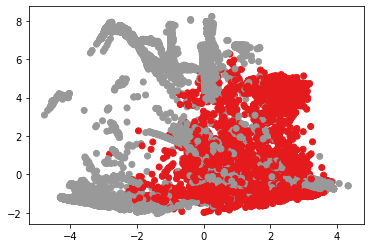

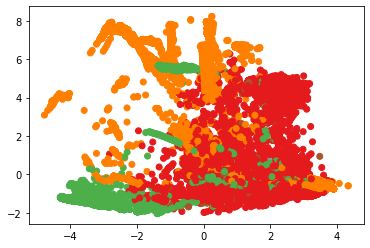

11.937225103378296


In [36]:
t0 = time()
viz_train_data = np.array(pca_train_df.rdd.map(lambda row: [*row['pca_features'], row['labels2_index'], row['labels5_index']]).collect())
plt.figure()
plt.scatter(x=viz_train_data[:,0], y=viz_train_data[:,1], c=viz_train_data[:,2], cmap="Set1")
plt.figure()
plt.scatter(x=viz_train_data[:,0], y=viz_train_data[:,1], c=viz_train_data[:,3], cmap="Set1")
plt.show()
print(time() - t0)

## 8. KMeans clustering with Random Forest Classifiers

The idea of the first approach is to clusterize data into clusters and then train different Random Forest classifiers for each of the clusters. As Random Forest returns probabilities, it is possible to improve detection rate for a new types of attacks by adjusting threshold.

As KMeans cannot truly handle binary/categorical features only numeric features are used for clustarization.

In [37]:
kmeans_prob_col = 'kmeans_rf_prob'
kmeans_pred_col = 'kmeans_rf_pred'

prob_cols.append(kmeans_prob_col)
pred_cols.append(kmeans_pred_col)

In [38]:
# KMeans clustrering
from pyspark.ml.clustering import KMeans

t0 = time()
kmeans_slicer = VectorSlicer(inputCol="indexed_features", outputCol="features", 
                             names=list(set(selectFeaturesByAR(ar_dict, 0.1)).intersection(numeric_cols)))

kmeans = KMeans(k=8, initSteps=25, maxIter=100, featuresCol="features", predictionCol="cluster", seed=seed)

kmeans_pipeline = Pipeline(stages=[kmeans_slicer, kmeans])

kmeans_model = kmeans_pipeline.fit(scaled_train_df)

kmeans_train_df = kmeans_model.transform(scaled_train_df).cache()
kmeans_cv_df = kmeans_model.transform(scaled_cv_df).cache()
kmeans_test_df = kmeans_model.transform(scaled_test_df).cache()

print(f"Time: {time() - t0:.2f}s")

Time: 6.53s


In [39]:
# Function for describing the contents of the clusters 
def getClusterCrosstab(df, clusterCol='cluster'):
    return (df.crosstab(clusterCol, 'labels2')
              .withColumn('count', col('attack') + col('normal'))
              .withColumn(clusterCol + '_labels2', col(clusterCol + '_labels2').cast('int'))
              .sort(col(clusterCol +'_labels2').asc()))

In [40]:
kmeans_crosstab = getClusterCrosstab(kmeans_train_df).cache()
kmeans_crosstab.show(n=30)

+---------------+------+------+-----+
|cluster_labels2|attack|normal|count|
+---------------+------+------+-----+
|              0|  3582|  4273| 7855|
|              1|   224|   398|  622|
|              2| 27727|    99|27826|
|              3|  5489| 46749|52238|
|              4|  2172|   178| 2350|
|              5|     2|    11|   13|
|              6|  7627|  2265| 9892|
|              7|     2|    42|   44|
+---------------+------+------+-----+



Clustres are splitted into two categories. Frist category contains clusters that have both 'attack' and 'normal' connections and have more than 25 connections. For the first category Random Forest classifiers are aplied. Second category contains all other clusters and maps cluster to 'attack' or 'normal' based on majority. All clusters that contains less or equal than 25 connections are treated as outliers and are mapped to 'attack' type.

In [41]:
# Function for splitting clusters
def splitClusters(crosstab):
    exp = ((col('count') > 25) & (col('attack') > 0) & (col('normal') > 0))

    cluster_rf = (crosstab
        .filter(exp).rdd
        .map(lambda row: (int(row['cluster_labels2']), [row['count'], row['attack']/row['count']]))
        .collectAsMap())

    cluster_mapping = (crosstab
        .filter(~exp).rdd
        .map(lambda row: (int(row['cluster_labels2']), 1.0 if (row['count'] <= 25) | (row['normal'] == 0) else 0.0))
        .collectAsMap())
    
    return cluster_rf, cluster_mapping

kmeans_cluster_rf, kmeans_cluster_mapping = splitClusters(kmeans_crosstab)

print(len(kmeans_cluster_rf), len(kmeans_cluster_mapping))
print(kmeans_cluster_mapping)
kmeans_cluster_rf

7 1
{5: 1.0}


{0: [7855, 0.4560152768936983],
 1: [622, 0.36012861736334406],
 2: [27826, 0.9964421763818012],
 3: [52238, 0.10507676404150236],
 4: [2350, 0.9242553191489362],
 6: [9892, 0.7710270926000808],
 7: [44, 0.045454545454545456]}

In [42]:
from pyspark.ml.classification import RandomForestClassifier

# This function returns Random Forest models for provided clusters
def getClusterModels(df, cluster_rf):
    cluster_models = {}

    labels_col = 'labels2_cl_index'
    labels2_indexer.setOutputCol(labels_col)

    rf_slicer = VectorSlicer(inputCol="indexed_features", outputCol="rf_features", 
                             names=selectFeaturesByAR(ar_dict, 0.05))

    for cluster in cluster_rf.keys():
        t1 = time()
        rf_classifier = RandomForestClassifier(labelCol=labels_col, featuresCol='rf_features', seed=seed,
                                               numTrees=500, maxDepth=20, featureSubsetStrategy="sqrt")
        
        rf_pipeline = Pipeline(stages=[labels2_indexer, rf_slicer, rf_classifier])
        cluster_models[cluster] = rf_pipeline.fit(df.filter(col('cluster') == cluster))
        print("Finished %g cluster in %g s" % (cluster, time() - t1))
        
    return cluster_models

In [43]:
# This utility function helps to get predictions/probabilities for the new data and return them into one dataframe
def getProbabilities(df, probCol, cluster_mapping, cluster_models):
    pred_df = (sqlContext.createDataFrame([], StructType([
                    StructField('id', LongType(), False),
                    StructField(probCol, DoubleType(), False)])))
    
    udf_map = udf(lambda cluster: cluster_mapping[cluster], DoubleType())
    pred_df = pred_df.union(df.filter(col('cluster').isin(list(cluster_mapping.keys())))
                            .withColumn(probCol, udf_map(col('cluster')))
                            .select('id', probCol))

                                       
    for k in cluster_models.keys():
        maj_label = cluster_models[k].stages[0].labels[0]
        udf_remap_prob = udf(lambda row: float(row[0]) if (maj_label == 'attack') else float(row[1]), DoubleType())

        pred_df = pred_df.union(cluster_models[k]
                         .transform(df.filter(col('cluster') == k))
                         .withColumn(probCol, udf_remap_prob(col('probability')))
                         .select('id', probCol))

    return pred_df

In [44]:
# Training Random Forest classifiers for each of the clusters
t0 = time()
kmeans_cluster_models = getClusterModels(kmeans_train_df, kmeans_cluster_rf)
print(f"Time: {time() - t0:.2f}s")

Finished 0 cluster in 17.8515 s
Finished 1 cluster in 2.84766 s
Finished 2 cluster in 26.4936 s
Finished 3 cluster in 256.526 s
Finished 4 cluster in 3.38144 s
Finished 6 cluster in 22.1199 s
Finished 7 cluster in 0.931688 s
Time: 330.16s


In [45]:
# Getting probabilities for CV data
t0 = time()
res_cv_df = (res_cv_df.drop(kmeans_prob_col)
             .join(getProbabilities(kmeans_cv_df, kmeans_prob_col, kmeans_cluster_mapping, kmeans_cluster_models), 'id')
             .cache())

print(res_cv_df.count())
print(f"Time: {time() - t0:.2f}s")

25133
Time: 24.28s


In [46]:
# Getting probabilities for Test data
t0 = time()
res_test_df = (res_test_df.drop(kmeans_prob_col)
               .join(getProbabilities(kmeans_test_df, kmeans_prob_col, kmeans_cluster_mapping, kmeans_cluster_models), 'id')
               .cache())

print(res_test_df.count())
print(f"Time: {time() - t0:.2f}s")

22544
Time: 20.52s


As CV data is from the same distribution as the train data it isn't needed to adjust threshold.

In [47]:
printReport(res_cv_df, kmeans_prob_col, e=0.5, labels=labels2)

      	normal	attack	
normal	 13314	    14	
attack	    37	 11768	
 
Accuracy = 0.997971
AUC = 0.997908
 
False Alarm Rate = 0.00105042
Detection Rate = 0.996866
F1 score = 0.997838
 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13328
         1.0       1.00      1.00      1.00     11805

    accuracy                           1.00     25133
   macro avg       1.00      1.00      1.00     25133
weighted avg       1.00      1.00      1.00     25133

 


Because test data is from the different distribution and it is expected to face unseen attack types, it makes sence to adjust a probability threshold to something like 0.01 for attack connections (0.99 for normal connections). For this approach it gives around ~98-99% Detection Rate with around ~14-15% of False Alarm Rate.

In [48]:
printReport(res_test_df, kmeans_prob_col, e=0.01, labels=labels2)

      	normal	attack	
normal	  8293	  1418	
attack	   183	 12650	
 
Accuracy = 0.928983
AUC = 0.91986
 
False Alarm Rate = 0.14602
Detection Rate = 0.98574
F1 score = 0.940485
 
              precision    recall  f1-score   support

         0.0       0.98      0.85      0.91      9711
         1.0       0.90      0.99      0.94     12833

    accuracy                           0.93     22544
   macro avg       0.94      0.92      0.93     22544
weighted avg       0.93      0.93      0.93     22544

 


In [49]:
# Adding prediction columns based on chosen thresholds into result dataframes
t0 = time()
res_cv_df = res_cv_df.withColumn(kmeans_pred_col, getPrediction(0.5)(col(kmeans_prob_col))).cache()
res_test_df = res_test_df.withColumn(kmeans_pred_col, getPrediction(0.01)(col(kmeans_prob_col))).cache()

print(res_cv_df.count())
print(res_test_df.count())
print(f"Time: {time() - t0:.2f}s")

25133
22544
Time: 34.49s


## 9. Gaussian Mixture clustering with Random Forest Classifiers

The idea of this approach is to clusterize data into clusters via Gaussian Mixture and then train different Random Forest classifiers for each of the clusters. Gaussian Mixture produces a diffirent clustering than KMeans, so results from both approaches could be combine for improving performance. As Gaussian Mixture clustering doesn't work well on high-demensional data PCA algorithm is used for preprocessing.

In [50]:
gm_prob_col = 'gm_rf_prob'
gm_pred_col = 'gm_rf_pred'

prob_cols.append(gm_prob_col)
pred_cols.append(gm_pred_col)

In [51]:
# Gaussian Mixture clustering
from pyspark.ml.clustering import GaussianMixture

t0 = time()
gm = GaussianMixture(k=8, maxIter=150, seed=seed, featuresCol="pca_features", 
                     predictionCol="cluster", probabilityCol="gm_prob")

gm_pipeline = Pipeline(stages=[pca_slicer, pca, gm])
gm_model = gm_pipeline.fit(scaled_train_df)

gm_train_df = gm_model.transform(scaled_train_df).cache()
gm_cv_df = gm_model.transform(scaled_cv_df).cache()
gm_test_df = gm_model.transform(scaled_test_df).cache()

gm_params = (gm_model.stages[2].gaussiansDF.rdd
                  .map(lambda row: [row['mean'].toArray(), row['cov'].toArray()])
                  .collect())
gm_weights = gm_model.stages[2].weights

print(gm_train_df.count())
print(gm_cv_df.count())
print(gm_test_df.count())
print(f"Time: {time() - t0:.2f}s")

100840
25133
22544
Time: 15.03s


In [52]:
# Description of the contents of the clusters 
gm_crosstab = getClusterCrosstab(gm_train_df).cache()
gm_crosstab.show(n=30)

+---------------+------+------+-----+
|cluster_labels2|attack|normal|count|
+---------------+------+------+-----+
|              0|  4091|     0| 4091|
|              1|    37|  1848| 1885|
|              2| 22917|     0|22917|
|              3|  5481|     0| 5481|
|              4|  7517| 19873|27390|
|              5|  2540|  5153| 7693|
|              6|  4213|   316| 4529|
|              7|    29| 26825|26854|
+---------------+------+------+-----+



In [53]:
# Splitting clusters
gm_cluster_rf, gm_cluster_mapping = splitClusters(gm_crosstab)

print(len(gm_cluster_rf), len(gm_cluster_mapping))
print(gm_cluster_mapping)
gm_cluster_rf

5 3
{0: 1.0, 2: 1.0, 3: 1.0}


{1: [1885, 0.019628647214854113],
 4: [27390, 0.27444322745527566],
 5: [7693, 0.3301702846743793],
 6: [4529, 0.9302274232722455],
 7: [26854, 0.0010799136069114472]}

In [54]:
# Training Random Forest classifiers for each of the clusters
t0 = time()
gm_cluster_models = getClusterModels(gm_train_df, gm_cluster_rf)
print(f"Time: {time() - t0:.2f}s")

Finished 1 cluster in 2.26199 s
Finished 4 cluster in 157.741 s
Finished 5 cluster in 49.1167 s
Finished 6 cluster in 9.94206 s
Finished 7 cluster in 6.31671 s
Time: 225.39s


In [55]:
# Getting probabilities for CV data
t0 = time()
res_cv_df = (res_cv_df.drop(gm_prob_col)
             .join(getProbabilities(gm_cv_df, gm_prob_col, gm_cluster_mapping, gm_cluster_models), 'id')
             .cache())

print(res_cv_df.count())
print(f"Time: {time() - t0:.2f}s")

25133
Time: 35.36s


In [56]:
# Getting probabilities for Test data
t0 = time()
res_test_df = (res_test_df.drop(gm_prob_col)
               .join(getProbabilities(gm_test_df, gm_prob_col, gm_cluster_mapping, gm_cluster_models), 'id')
               .cache())

print(res_test_df.count())
print(f"Time: {time() - t0:.2f}s")

22544
Time: 32.74s


In [57]:
printReport(res_cv_df, gm_prob_col, e=0.5, labels=labels2)

      	normal	attack	
normal	 13321	     7	
attack	    34	 11771	
 
Accuracy = 0.998369
AUC = 0.998297
 
False Alarm Rate = 0.00052521
Detection Rate = 0.99712
F1 score = 0.998261
 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13328
         1.0       1.00      1.00      1.00     11805

    accuracy                           1.00     25133
   macro avg       1.00      1.00      1.00     25133
weighted avg       1.00      1.00      1.00     25133

 


In [58]:
printReport(res_test_df, gm_prob_col, e=0.01, labels=labels2)

      	normal	attack	
normal	  8279	  1432	
attack	   424	 12409	
 
Accuracy = 0.917672
AUC = 0.909749
 
False Alarm Rate = 0.147462
Detection Rate = 0.96696
F1 score = 0.930419
 
              precision    recall  f1-score   support

         0.0       0.95      0.85      0.90      9711
         1.0       0.90      0.97      0.93     12833

    accuracy                           0.92     22544
   macro avg       0.92      0.91      0.91     22544
weighted avg       0.92      0.92      0.92     22544

 


In [59]:
# Adding prediction columns based on chosen thresholds into result dataframes
t0 = time()
res_cv_df = res_cv_df.withColumn(gm_pred_col, getPrediction(0.5)(col(gm_prob_col))).cache()
res_test_df = res_test_df.withColumn(gm_pred_col, getPrediction(0.01)(col(gm_prob_col))).cache()

print(res_cv_df.count())
print(res_test_df.count())
print(f"Time: {time() - t0:.2f}s")

25133
22544
Time: 31.65s


## 10. Supervised approach for dettecting each type of attacks separately

The idea of the following approach is training Random Forest Classifiers for each of four major 'attack' categories separately.

### 10.1 DoS and normal

In [60]:
dos_prob_col = 'dos_prob'
dos_pred_col = 'dos_pred'

prob_cols.append(dos_prob_col)
pred_cols.append(dos_pred_col)

In [61]:
dos_exp = (col('labels5') == 'DoS') | (col('labels5') == 'normal')
dos_train_df = (scaled_train_df.filter(dos_exp).cache())

print(dos_train_df.count())
(dos_train_df
     .groupby('labels5')
     .count()
     .sort(sql.desc('count'))
     .show())

90750
+-------+-----+
|labels5|count|
+-------+-----+
| normal|54015|
|    DoS|36735|
+-------+-----+



Commented code below is related to undersampling 'normal' connections. It could give better results. However, it hasen't been tested a lot yet.

In [62]:
# dos_train_df = dos_train_df.sampleBy('labels5', fractions={'normal': 45927./67343, 'DoS': 1.0}).cache()

# print(dos_train_df.count())
# (dos_train_df
#      .groupby('labels5')
#      .count()
#      .sort(sql.desc('count'))
#      .show())

Diffirent AR feature selection is used as only normal and DoS connections are treated. Note that train dataframe without standartization is used for getting Attribute Ratio dictionary.

In [63]:
t0 = time()
dos_ar_dict = getAttributeRatio(train_df.filter(dos_exp), numeric_cols, binary_cols, 'labels5')

print(f"Time: {time() - t0:.2f}s")
dos_ar_dict

Time: 6.62s


OrderedDict([('flag_SF', 16.04886075949367),
             ('protocol_type_tcp', 11.283230810377106),
             ('flag_S0', 2.965034965034965),
             ('wrong_fragment', 2.4663052235068696),
             ('logged_in', 2.4559683875603),
             ('dst_host_srv_serror_rate', 2.4369460592636014),
             ('srv_serror_rate', 2.4091388710886883),
             ('serror_rate', 2.403031496724026),
             ('dst_host_serror_rate', 2.400741230991577),
             ('count', 2.0805650842389314),
             ('rerror_rate', 1.729470874459902),
             ('srv_rerror_rate', 1.7274542811973763),
             ('dst_host_srv_rerror_rate', 1.7208022988464688),
             ('dst_host_rerror_rate', 1.7204184332241286),
             ('num_failed_logins', 1.6819862494988345),
             ('num_root', 1.6819862494988345),
             ('urgent', 1.6819862494988342),
             ('num_file_creations', 1.6819862494988342),
             ('num_shells', 1.6819862494988342),
         

In [64]:
t0 = time()
dos_slicer = VectorSlicer(inputCol="indexed_features", outputCol="features", 
                          names=selectFeaturesByAR(dos_ar_dict, 0.05))

dos_rf = RandomForestClassifier(labelCol=labels_col, featuresCol='features', featureSubsetStrategy='sqrt',
                                numTrees=500, maxDepth=20, seed=seed)

dos_rf_pipeline = Pipeline(stages=[dos_slicer, dos_rf])
dos_rf_model = dos_rf_pipeline.fit(dos_train_df)

dos_cv_df = dos_rf_model.transform(scaled_cv_df).cache()
dos_test_df = dos_rf_model.transform(scaled_test_df).cache()
print(dos_cv_df.count())
print(dos_test_df.count())

print(f"Time: {time() - t0:.2f}s")

25133
22544
Time: 212.05s


In [65]:
# Getting probabilities for CV data
t0 = time()
res_cv_df = (res_cv_df.drop(dos_prob_col)
             .join(dos_cv_df.rdd
                    .map(lambda row: (row['id'], float(row['probability'][1])))
                    .toDF(['id', dos_prob_col]),
                    'id')
                    .cache())

print(res_cv_df.count())
print(f"Time: {time() - t0:.2f}s")

25133
Time: 15.69s


In [66]:
# Getting probabilities for Test data
t0 = time()
res_test_df = (res_test_df.drop(dos_prob_col)
               .join(dos_test_df.rdd
                    .map(lambda row: (row['id'], float(row['probability'][1])))
                    .toDF(['id', dos_prob_col]),
                    'id')
                    .cache())

print(res_test_df.count())
print(f"Time: {time() - t0:.2f}s")

22544
Time: 13.09s


The first report shows performance of classification for 'normal' and 'DoS' labels, the second report shows performance for the whole data with adjusted threshold.

In [67]:
printReport(res_cv_df.filter(dos_exp), probCol=dos_prob_col, e=0.5, labels=['normal', 'DoS'])
printReport(res_cv_df, probCol=dos_prob_col, e=0.05)

      	normal	   DoS	
normal	 13327	     1	
   DoS	     3	  9189	
 
Accuracy = 0.999822
AUC = 0.999799
 
False Alarm Rate = 7.503e-05
Detection Rate = 0.999674
F1 score = 0.999782
 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13328
         1.0       1.00      1.00      1.00      9192

    accuracy                           1.00     22520
   macro avg       1.00      1.00      1.00     22520
weighted avg       1.00      1.00      1.00     22520

 
      	normal	attack	
normal	 13247	    81	
attack	   415	 11390	
 
Accuracy = 0.980265
AUC = 0.979384
 
False Alarm Rate = 0.00607743
Detection Rate = 0.964845
F1 score = 0.97869
 
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     13328
         1.0       0.99      0.96      0.98     11805

    accuracy                           0.98     25133
   macro avg       0.98      0.98      0.98     25133
weighted avg       0.98      0.98  

In [68]:
printReport(res_test_df.filter(dos_exp), probCol=dos_prob_col, e=0.5, labels=['normal', 'DoS'])
printReport(res_test_df, probCol=dos_prob_col, e=0.01)

      	normal	   DoS	
normal	  9624	    87	
   DoS	  1473	  5985	
 
Accuracy = 0.909139
AUC = 0.896768
 
False Alarm Rate = 0.00895891
Detection Rate = 0.802494
F1 score = 0.884701
 
              precision    recall  f1-score   support

         0.0       0.87      0.99      0.93      9711
         1.0       0.99      0.80      0.88      7458

    accuracy                           0.91     17169
   macro avg       0.93      0.90      0.90     17169
weighted avg       0.92      0.91      0.91     17169

 
      	normal	attack	
normal	  8759	   952	
attack	  2782	 10051	
 
Accuracy = 0.834368
AUC = 0.842591
 
False Alarm Rate = 0.0980332
Detection Rate = 0.783215
F1 score = 0.843346
 
              precision    recall  f1-score   support

         0.0       0.76      0.90      0.82      9711
         1.0       0.91      0.78      0.84     12833

    accuracy                           0.83     22544
   macro avg       0.84      0.84      0.83     22544
weighted avg       0.85      0.83 

In [69]:
# Adding prediction columns based on chosen thresholds into result dataframes
t0 = time()
res_cv_df = res_cv_df.withColumn(dos_pred_col, getPrediction(0.05)(col(dos_prob_col))).cache()
res_test_df = res_test_df.withColumn(dos_pred_col, getPrediction(0.01)(col(dos_prob_col))).cache()

print(res_cv_df.count())
print(res_test_df.count())
print(f"Time: {time() - t0:.2f}s")

25133
22544
Time: 5.51s


### 10.2 Probe and normal

In [70]:
probe_prob_col = 'probe_prob'
probe_pred_col = 'probe_pred'

prob_cols.append(probe_prob_col)
pred_cols.append(probe_pred_col)

In [71]:
probe_exp = (col('labels5') == 'Probe') | (col('labels5') == 'normal')
probe_train_df = (scaled_train_df.filter(probe_exp).cache())

print(probe_train_df.count())
(probe_train_df
     .groupby('labels5')
     .count()
     .sort(sql.desc('count'))
     .show())

63286
+-------+-----+
|labels5|count|
+-------+-----+
| normal|54015|
|  Probe| 9271|
+-------+-----+



Commented code below is related to undersampling 'normal' connections. It could give better results. However, it hasen't been tested a lot yet.

In [72]:
# probe_train_df = probe_train_df.sampleBy('labels5', fractions={'normal': 9274./53789, 'Probe': 1.0}).cache()

# print(probe_train_df.count())
# (probe_train_df
#      .groupby('labels5')
#      .count()
#      .sort(sql.desc('count'))
#      .show())

Diffirent AR feature selection is used as only normal and Probe connections are treated. Note that train dataframe without standartization is used for getting Attribute Ratio dictionary.

In [73]:
t0 = time()
probe_ar_dict = getAttributeRatio(train_df.filter(probe_exp), numeric_cols, binary_cols, 'labels5')

print(f"Time: {time() - t0:.2f}s")
probe_ar_dict

Time: 4.46s


OrderedDict([('flag_SF', 16.04886075949367),
             ('dst_bytes', 5.954890189917854),
             ('src_bytes', 5.663342453521275),
             ('duration', 4.612329795738909),
             ('dst_host_diff_srv_rate', 4.295388446518038),
             ('srv_rerror_rate', 4.289248359824753),
             ('rerror_rate', 4.279060093009581),
             ('dst_host_srv_rerror_rate', 4.274560348159813),
             ('diff_srv_rate', 4.111925438331699),
             ('dst_host_rerror_rate', 4.008755744761299),
             ('protocol_type_tcp', 3.900167357927672),
             ('dst_host_srv_diff_host_rate', 3.761764380647146),
             ('dst_host_srv_serror_rate', 3.5899755168448144),
             ('dst_host_same_src_port_rate', 3.260144247441684),
             ('serror_rate', 2.5392653643867047),
             ('count', 2.520990695784333),
             ('srv_serror_rate', 2.475062409348203),
             ('logged_in', 2.4559683875603),
             ('dst_host_serror_rate', 2.422

In [74]:
t0 = time()
probe_slicer = VectorSlicer(inputCol="indexed_features", outputCol="features",
                            names=selectFeaturesByAR(probe_ar_dict, 0.05))

probe_rf = RandomForestClassifier(labelCol=labels_col, featuresCol='features', featureSubsetStrategy='sqrt',
                                  numTrees=500, maxDepth=20, seed=seed)
probe_rf_pipeline = Pipeline(stages=[probe_slicer, probe_rf])

probe_rf_model = probe_rf_pipeline.fit(probe_train_df)

probe_cv_df = probe_rf_model.transform(scaled_cv_df).cache()
probe_test_df = probe_rf_model.transform(scaled_test_df).cache()

print(probe_cv_df.count())
print(probe_test_df.count())
print(f"Time: {time() - t0:.2f}s")

25133
22544
Time: 222.12s


In [75]:
# Getting probabilities for CV data
t0 = time()
res_cv_df = (res_cv_df.drop(probe_prob_col)
             .join(probe_cv_df.rdd
                    .map(lambda row: (row['id'], float(row['probability'][1])))
                    .toDF(['id', probe_prob_col]), 'id')
                    .cache())

print(res_cv_df.count())
print(f"Time: {time() - t0:.2f}s")

25133
Time: 4.96s


In [76]:
# Getting probabilities for Test data
t0 = time()
res_test_df = (res_test_df.drop(probe_prob_col)
               .join(probe_test_df.rdd
                    .map(lambda row: (row['id'], float(row['probability'][1])))
                    .toDF(['id', probe_prob_col]), 'id')
                    .cache())

print(res_test_df.count())
print(f"Time: {time() - t0:.2f}s")

22544
Time: 4.36s


The first report shows performance of classification for 'normal' and 'Probe' labels, the second report shows performance for the whole data with adjusted threshold.

In [77]:
printReport(res_cv_df.filter(probe_exp), probCol=probe_prob_col, e=0.5, labels=['normal', 'Probe'])
printReport(res_cv_df, probCol=probe_prob_col, e=0.05)

      	normal	 Probe	
normal	 13324	     4	
 Probe	    13	  2372	
 
Accuracy = 0.998918
AUC = 0.997125
 
False Alarm Rate = 0.00030012
Detection Rate = 0.994549
F1 score = 0.996429
 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13328
         1.0       1.00      0.99      1.00      2385

    accuracy                           1.00     15713
   macro avg       1.00      1.00      1.00     15713
weighted avg       1.00      1.00      1.00     15713

 
      	normal	attack	
normal	 13133	   195	
attack	   417	 11388	
 
Accuracy = 0.97565
AUC = 0.975023
 
False Alarm Rate = 0.0146309
Detection Rate = 0.964676
F1 score = 0.973833
 
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     13328
         1.0       0.98      0.96      0.97     11805

    accuracy                           0.98     25133
   macro avg       0.98      0.98      0.98     25133
weighted avg       0.98      0.98  

In [78]:
printReport(res_test_df.filter(probe_exp), probCol=probe_prob_col, e=0.5, labels=['normal', 'Probe'])
printReport(res_test_df, probCol=probe_prob_col, e=0.01)

      	normal	 Probe	
normal	  9498	   213	
 Probe	   969	  1452	
 
Accuracy = 0.902572
AUC = 0.788909
 
False Alarm Rate = 0.0219339
Detection Rate = 0.599752
F1 score = 0.71072
 
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94      9711
         1.0       0.87      0.60      0.71      2421

    accuracy                           0.90     12132
   macro avg       0.89      0.79      0.83     12132
weighted avg       0.90      0.90      0.90     12132

 
      	normal	attack	
normal	  8436	  1275	
attack	  2047	 10786	
 
Accuracy = 0.852644
AUC = 0.854597
 
False Alarm Rate = 0.131294
Detection Rate = 0.840489
F1 score = 0.866554
 
              precision    recall  f1-score   support

         0.0       0.80      0.87      0.84      9711
         1.0       0.89      0.84      0.87     12833

    accuracy                           0.85     22544
   macro avg       0.85      0.85      0.85     22544
weighted avg       0.86      0.85    

In [79]:
# Adding prediction columns based on chosen thresholds into result dataframes
t0 = time()
res_cv_df = res_cv_df.withColumn(probe_pred_col, getPrediction(0.05)(col(probe_prob_col))).cache()
res_test_df = res_test_df.withColumn(probe_pred_col, getPrediction(0.01)(col(probe_prob_col))).cache()

print(res_cv_df.count())
print(res_test_df.count())
print(f"Time: {time() - t0:.2f}s")

25133
22544
Time: 4.88s


### 10.3 R2L, U2R and normal types

As there are a few examples of both R2L and U2R attack types and they have similar behaviour, they are combined into one group.

In [80]:
r2l_u2r_prob_col = 'r2l_u2r_prob'
r2l_u2r_pred_col = 'r2l_u2r_pred'

prob_cols.append(r2l_u2r_prob_col)
pred_cols.append(r2l_u2r_pred_col)

In [81]:
r2l_u2r_exp = (col('labels5') == 'R2L') | (col('labels5') == 'U2R') | (col('labels5') == 'normal')
r2l_u2r_train_df = (scaled_train_df.filter(r2l_u2r_exp).cache())

print(r2l_u2r_train_df.count())
(r2l_u2r_train_df
     .groupby('labels5')
     .count()
     .sort(sql.desc('count'))
     .show())

54834
+-------+-----+
|labels5|count|
+-------+-----+
| normal|54015|
|    R2L|  782|
|    U2R|   37|
+-------+-----+



Diffirent AR feature selection is used as only normal, R2L and U2R connections are treated. Note that train dataframe without standartization is used for getting Attribute Ratio dictionary.

In [82]:
t0 = time()
r2l_u2r_ar_dict = getAttributeRatio(train_df.filter(r2l_u2r_exp), numeric_cols, binary_cols, 'labels5')

print(f"Time: {time() - t0:.2f}s")
r2l_u2r_ar_dict

Time: 5.22s


OrderedDict([('protocol_type_tcp', 1000.0),
             ('num_shells', 177.04511834319524),
             ('urgent', 93.9423076923077),
             ('flag_SF', 51.0),
             ('num_file_creations', 34.215028309254194),
             ('num_failed_logins', 25.660569514237856),
             ('hot', 23.850718086856727),
             ('src_bytes', 17.67531409051069),
             ('dst_bytes', 14.991946554922052),
             ('logged_in', 10.569767441860465),
             ('dst_host_same_src_port_rate', 4.6280053915595785),
             ('duration', 3.6136716211332516),
             ('dst_host_srv_diff_host_rate', 3.186499677327565),
             ('serror_rate', 2.8336950817010025),
             ('dst_host_srv_serror_rate', 2.550033066061569),
             ('num_access_files', 2.5488223017292784),
             ('num_compromised', 2.416504765066944),
             ('diff_srv_rate', 2.2340127157717946),
             ('service_telnet', 1.8888888888888888),
             ('dst_host_serror_

In [83]:
t0 = time()
r2l_u2r_slicer = VectorSlicer(inputCol="indexed_features", outputCol="features",
                              names=selectFeaturesByAR(r2l_u2r_ar_dict, 0.05))

r2l_u2r_rf = RandomForestClassifier(labelCol=labels_col, featuresCol='features', featureSubsetStrategy='sqrt',
                                    numTrees=500, maxDepth=20, seed=seed)
r2l_u2r_rf_pipeline = Pipeline(stages=[r2l_u2r_slicer, r2l_u2r_rf])

r2l_u2r_rf_model = r2l_u2r_rf_pipeline.fit(r2l_u2r_train_df)

r2l_u2r_cv_df = r2l_u2r_rf_model.transform(scaled_cv_df).cache()
r2l_u2r_test_df = r2l_u2r_rf_model.transform(scaled_test_df).cache()
print(r2l_u2r_cv_df.count())
print(r2l_u2r_test_df.count())

print(f"Time: {time() - t0:.2f}s")

25133
22544
Time: 187.78s


In [84]:
# Getting probabilities for CV data
t0 = time()
res_cv_df = (res_cv_df.drop(r2l_u2r_prob_col)
             .join(r2l_u2r_cv_df.rdd
                    .map(lambda row: (row['id'], float(row['probability'][1])))
                    .toDF(['id', r2l_u2r_prob_col]), 'id')
                    .cache())

print(res_cv_df.count())
print(f"Time: {time() - t0:.2f}s")

25133
Time: 5.90s


In [85]:
# Getting probabilities for Test data
t0 = time()
res_test_df = (res_test_df.drop(r2l_u2r_prob_col)
               .join(r2l_u2r_test_df.rdd
                    .map(lambda row: (row['id'], float(row['probability'][1])))
                    .toDF(['id', r2l_u2r_prob_col]), 'id')
                    .cache())

print(res_test_df.count())
print(f"Time: {time() - t0:.2f}s")

22544
Time: 4.37s


The first report shows performance of classification for 'normal' and 'R2L&U2R' labels, the second report shows performance for the whole data with adjusted threshold.

In [86]:
printReport(res_cv_df.filter(r2l_u2r_exp), probCol=r2l_u2r_prob_col, e=0.5, labels=['normal', 'R2L&U2R'])
printReport(res_cv_df, probCol=r2l_u2r_prob_col, e=0.05, labels=labels2)

       	 normal	R2L&U2R	
 normal	  13324	      4	
R2L&U2R	     15	    213	
 
Accuracy = 0.998598
AUC = 0.966955
 
False Alarm Rate = 0.00030012
Detection Rate = 0.934211
F1 score = 0.957303
 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13328
         1.0       0.98      0.93      0.96       228

    accuracy                           1.00     13556
   macro avg       0.99      0.97      0.98     13556
weighted avg       1.00      1.00      1.00     13556

 
      	normal	attack	
normal	 13246	    82	
attack	  4758	  7047	
 
Accuracy = 0.807425
AUC = 0.795399
 
False Alarm Rate = 0.00615246
Detection Rate = 0.59695
F1 score = 0.744375
 
              precision    recall  f1-score   support

         0.0       0.74      0.99      0.85     13328
         1.0       0.99      0.60      0.74     11805

    accuracy                           0.81     25133
   macro avg       0.86      0.80      0.79     25133
weighted avg       0.85  

In [87]:
printReport(res_test_df.filter(r2l_u2r_exp), probCol=r2l_u2r_prob_col, e=0.5, labels=['normal', 'R2L&U2R'])
printReport(res_test_df, probCol=r2l_u2r_prob_col, e=0.01, labels=labels2)

       	 normal	R2L&U2R	
 normal	   9709	      2	
R2L&U2R	   2653	    301	
 
Accuracy = 0.790367
AUC = 0.550845
 
False Alarm Rate = 0.000205952
Detection Rate = 0.101896
F1 score = 0.184833
 
              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88      9711
         1.0       0.99      0.10      0.18      2954

    accuracy                           0.79     12665
   macro avg       0.89      0.55      0.53     12665
weighted avg       0.83      0.79      0.72     12665

 
      	normal	attack	
normal	  9413	   298	
attack	  5934	  6899	
 
Accuracy = 0.723563
AUC = 0.753456
 
False Alarm Rate = 0.0306868
Detection Rate = 0.537598
F1 score = 0.688867
 
              precision    recall  f1-score   support

         0.0       0.61      0.97      0.75      9711
         1.0       0.96      0.54      0.69     12833

    accuracy                           0.72     22544
   macro avg       0.79      0.75      0.72     22544
weighted avg       0.81 

In [88]:
# Adding prediction columns based on chosen thresholds into result dataframes
t0 = time()
res_cv_df = res_cv_df.withColumn(r2l_u2r_pred_col, getPrediction(0.05)(col(r2l_u2r_prob_col))).cache()
res_test_df = res_test_df.withColumn(r2l_u2r_pred_col, getPrediction(0.01)(col(r2l_u2r_prob_col))).cache()

print(res_cv_df.count())
print(res_test_df.count())
print(f"Time: {time() - t0:.2f}s")

25133
22544
Time: 4.46s


### 10.4 Combining results

In [89]:
sup_prob_col = 'sup_prob'
sup_pred_col = 'sup_pred'

prob_cols.append(sup_prob_col)
pred_cols.append(sup_pred_col)

In [90]:
res_cv_df = res_cv_df.withColumn(sup_prob_col, 
                                 (col(dos_prob_col) + col(probe_prob_col) + col(r2l_u2r_prob_col))/3).cache()

printReport(res_cv_df, sup_prob_col, e=0.05, labels=labels2)

      	normal	attack	
normal	 13198	   130	
attack	     3	 11802	
 
Accuracy = 0.994708
AUC = 0.994996
 
False Alarm Rate = 0.0097539
Detection Rate = 0.999746
F1 score = 0.994397
 
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     13328
         1.0       0.99      1.00      0.99     11805

    accuracy                           0.99     25133
   macro avg       0.99      0.99      0.99     25133
weighted avg       0.99      0.99      0.99     25133

 


In [91]:
res_cv_df = res_cv_df.withColumn(sup_pred_col, col(dos_pred_col).cast('int')
                                        .bitwiseOR(col(probe_pred_col).cast('int'))
                                        .bitwiseOR(col(r2l_u2r_pred_col).cast('int'))).cache()

printReport(res_cv_df, sup_pred_col, labels=labels2)

      	normal	attack	
normal	 13020	   308	
attack	     0	 11805	
 
Accuracy = 0.987745
AUC = 0.988445
 
False Alarm Rate = 0.0231092
Detection Rate = 1
F1 score = 0.987123
 
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     13328
         1.0       0.97      1.00      0.99     11805

    accuracy                           0.99     25133
   macro avg       0.99      0.99      0.99     25133
weighted avg       0.99      0.99      0.99     25133

 


In [92]:
res_test_df = res_test_df.withColumn(sup_prob_col, 
                                 (col(dos_prob_col) + col(probe_prob_col) + col(r2l_u2r_prob_col))/3).cache()

printReport(res_test_df, sup_prob_col, e=0.005, labels=labels2)

      	normal	attack	
normal	  8363	  1348	
attack	   830	 12003	
 
Accuracy = 0.903389
AUC = 0.898256
 
False Alarm Rate = 0.138812
Detection Rate = 0.935323
F1 score = 0.916819
 
              precision    recall  f1-score   support

         0.0       0.91      0.86      0.88      9711
         1.0       0.90      0.94      0.92     12833

    accuracy                           0.90     22544
   macro avg       0.90      0.90      0.90     22544
weighted avg       0.90      0.90      0.90     22544

 


In [93]:
res_test_df = res_test_df.withColumn(sup_pred_col, col(dos_pred_col).cast('int')
                                            .bitwiseOR(col(probe_pred_col).cast('int'))
                                            .bitwiseOR(col(r2l_u2r_pred_col).cast('int'))).cache()

printReport(res_test_df, sup_pred_col, labels=labels2)

      	normal	attack	
normal	  8330	  1381	
attack	   763	 12070	
 
Accuracy = 0.904897
AUC = 0.899167
 
False Alarm Rate = 0.14221
Detection Rate = 0.940544
F1 score = 0.918429
 
              precision    recall  f1-score   support

         0.0       0.92      0.86      0.89      9711
         1.0       0.90      0.94      0.92     12833

    accuracy                           0.90     22544
   macro avg       0.91      0.90      0.90     22544
weighted avg       0.91      0.90      0.90     22544

 


## 11. Ensembling experiments

Here are some experiments with ensembling and stacking results from different approaches.

### 11.1 Linear combination of all models

In [94]:
# Printing report of the best single model for comparison
printReport(res_test_df, kmeans_pred_col)

      	normal	attack	
normal	  8293	  1418	
attack	   183	 12650	
 
Accuracy = 0.928983
AUC = 0.91986
 
False Alarm Rate = 0.14602
Detection Rate = 0.98574
F1 score = 0.940485
 
              precision    recall  f1-score   support

         0.0       0.98      0.85      0.91      9711
         1.0       0.90      0.99      0.94     12833

    accuracy                           0.93     22544
   macro avg       0.94      0.92      0.93     22544
weighted avg       0.93      0.93      0.93     22544

 


In [95]:
# Linear combination of all models 
printReport(res_test_df
            .select('labels2_index', ((3 * col(kmeans_prob_col) \
                                        + col(gm_prob_col) \
                                        + col(dos_prob_col) \
                                        + col(probe_prob_col) \
                                        + col(r2l_u2r_prob_col))/7)
                    .alias('voting')), 
            'voting', e=0.005, labels=labels2)

      	normal	attack	
normal	  8171	  1540	
attack	    81	 12752	
 
Accuracy = 0.928096
AUC = 0.917553
 
False Alarm Rate = 0.158583
Detection Rate = 0.993688
F1 score = 0.94024
 
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91      9711
         1.0       0.89      0.99      0.94     12833

    accuracy                           0.93     22544
   macro avg       0.94      0.92      0.92     22544
weighted avg       0.93      0.93      0.93     22544

 


In [96]:
printReport(res_test_df
            .select('labels2_index', ((2 * col(kmeans_prob_col) \
                                        + col(gm_prob_col) \
                                        + col(sup_prob_col))/4)
                    .alias('voting')), 
            'voting', e=0.005, labels=labels2)

      	normal	attack	
normal	  8136	  1575	
attack	    57	 12776	
 
Accuracy = 0.927608
AUC = 0.916686
 
False Alarm Rate = 0.162187
Detection Rate = 0.995558
F1 score = 0.939965
 
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91      9711
         1.0       0.89      1.00      0.94     12833

    accuracy                           0.93     22544
   macro avg       0.94      0.92      0.92     22544
weighted avg       0.93      0.93      0.93     22544

 


In [97]:
printReport(res_test_df
            .select('labels2_index', (col(kmeans_pred_col).cast('int')
                                      .bitwiseOR(col(gm_pred_col).cast('int'))
                                      .bitwiseOR(col(sup_pred_col).cast('int')))
                    .alias('voting')), 
                    'voting', labels=labels2)

      	normal	attack	
normal	  8147	  1564	
attack	    91	 12742	
 
Accuracy = 0.926588
AUC = 0.915927
 
False Alarm Rate = 0.161054
Detection Rate = 0.992909
F1 score = 0.939018
 
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91      9711
         1.0       0.89      0.99      0.94     12833

    accuracy                           0.93     22544
   macro avg       0.94      0.92      0.92     22544
weighted avg       0.93      0.93      0.93     22544

 


### 11.2 Logistic Regression and Random Forest Classifier 

In [98]:
from pyspark.ml.classification import LogisticRegression

t0 = time()
lr_assembler = VectorAssembler(inputCols=[
                            kmeans_prob_col, 
                            gm_prob_col, 
                            dos_prob_col, 
                            probe_prob_col, 
                            r2l_u2r_prob_col
                            ], 
                            outputCol="features")

lr = LogisticRegression(maxIter=100, labelCol="labels2_index", standardization=False, weightCol='weights')
lr_pipeline = Pipeline(stages=[lr_assembler, lr])

weights_dict = {
    'normal': 1.0,
    'DoS': 100.0,
    'Probe': 100.0,
    'R2L': 100.0,
    'U2R': 100.0
}

udf_weight = udf(lambda row: weights_dict[row], DoubleType())
lr_model = lr_pipeline.fit(res_cv_df.withColumn('weights', udf_weight('labels5')))
lr_test_df = lr_model.transform(res_test_df).cache()

res_test_df = (res_test_df.drop('lr_prob')
                    .join(lr_test_df.rdd
                    .map(lambda row: (row['id'], float(row['probability'][1])))
                    .toDF(['id', 'lr_prob']), 'id')
                    .cache())

print(res_test_df.count())
print(f"Time: {time() - t0:.2f}s")

22544
Time: 73.75s


In [99]:
printReport(res_test_df, 'lr_prob', e=0.01, labels=labels2)

      	normal	attack	
normal	  6973	  2738	
attack	   541	 12292	
 
Accuracy = 0.854551
AUC = 0.837947
 
False Alarm Rate = 0.281948
Detection Rate = 0.957843
F1 score = 0.882317
 
              precision    recall  f1-score   support

         0.0       0.93      0.72      0.81      9711
         1.0       0.82      0.96      0.88     12833

    accuracy                           0.85     22544
   macro avg       0.87      0.84      0.85     22544
weighted avg       0.87      0.85      0.85     22544

 


In [100]:
t0 = time()
rf_assembler = VectorAssembler(inputCols=[
                            kmeans_pred_col, 
                            gm_pred_col, 
                            dos_pred_col, 
                            probe_pred_col, 
                            r2l_u2r_pred_col
                            ],
                            outputCol='features')

rf_indexer =  VectorIndexer(inputCol='features', outputCol='indexed_features', maxCategories=2)

rf = RandomForestClassifier(labelCol='labels2_index', featuresCol='features', seed=seed,
                            numTrees=250, maxDepth=5, featureSubsetStrategy='auto')
rf_pipeline = Pipeline(stages=[rf_assembler, 
                               rf_indexer,
                               rf])
rf_model = rf_pipeline.fit(res_cv_df)
rf_test_df = rf_model.transform(res_test_df).cache()

res_test_df = (res_test_df.drop('rf_prob')
                    .join(rf_test_df.rdd
                    .map(lambda row: (row['id'], float(row['probability'][1])))
                    .toDF(['id', 'rf_prob']), 'id')
                    .cache())

print(res_test_df.count())
print(f"Time: {time() - t0:.2f}s")

22544
Time: 16.53s


In [101]:
printReport(res_test_df, 'rf_prob', e=0.01, labels=labels2)

      	normal	attack	
normal	  8147	  1564	
attack	    91	 12742	
 
Accuracy = 0.926588
AUC = 0.915927
 
False Alarm Rate = 0.161054
Detection Rate = 0.992909
F1 score = 0.939018
 
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91      9711
         1.0       0.89      0.99      0.94     12833

    accuracy                           0.93     22544
   macro avg       0.94      0.92      0.92     22544
weighted avg       0.93      0.93      0.93     22544

 


In [102]:
# Adding prediction columns based on chosen thresholds into result dataframes
t0 = time()
res_test_df = res_test_df.withColumn('lr_pred', getPrediction(0.01)(col('lr_prob'))).cache()
res_test_df = res_test_df.withColumn('rf_pred', getPrediction(0.01)(col('rf_prob'))).cache()

print(res_test_df.count())
print(f"Time: {time() - t0:.2f}s")

22544
Time: 3.06s


In [103]:
printReport(res_test_df
            .select('labels2_index', ((col('lr_prob') + col('rf_prob'))/2)
                    .alias('voting')), 
                    'voting', e=0.01, labels=labels2)

      	normal	attack	
normal	  8147	  1564	
attack	    91	 12742	
 
Accuracy = 0.926588
AUC = 0.915927
 
False Alarm Rate = 0.161054
Detection Rate = 0.992909
F1 score = 0.939018
 
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91      9711
         1.0       0.89      0.99      0.94     12833

    accuracy                           0.93     22544
   macro avg       0.94      0.92      0.92     22544
weighted avg       0.93      0.93      0.93     22544

 


In [104]:
printReport(res_test_df
            .select('labels2_index', (col('lr_pred').cast('int').bitwiseOR(col('rf_pred').cast('int')))
                    .alias('voting')), 
                    'voting', labels=labels2)

      	normal	attack	
normal	  6883	  2828	
attack	    17	 12816	
 
Accuracy = 0.873802
AUC = 0.85373
 
False Alarm Rate = 0.291216
Detection Rate = 0.998675
F1 score = 0.900095
 
              precision    recall  f1-score   support

         0.0       1.00      0.71      0.83      9711
         1.0       0.82      1.00      0.90     12833

    accuracy                           0.87     22544
   macro avg       0.91      0.85      0.86     22544
weighted avg       0.90      0.87      0.87     22544

 


### 11.3 Stacking with Random Forest Classifier

In [105]:
stack_cv_df = scaled_cv_df.join(res_cv_df.select('id', *[
                            kmeans_pred_col, 
                            gm_pred_col, 
                            dos_pred_col, 
                            probe_pred_col, 
                            r2l_u2r_pred_col,
                            sup_pred_col
                            ]), 'id').cache()

stack_test_df = scaled_test_df.join(res_test_df.select('id', *[
                            kmeans_pred_col, 
                            gm_pred_col, 
                            dos_pred_col, 
                            probe_pred_col, 
                            r2l_u2r_pred_col,
                            sup_pred_col
                            ]), 'id').cache()

print(stack_cv_df.count())
print(stack_test_df.count())

25133
22544


In [106]:
t0 = time()
pred_assembler = VectorAssembler(inputCols=[
                            kmeans_pred_col, 
                            gm_pred_col, 
                            dos_pred_col, 
                            probe_pred_col, 
                            r2l_u2r_pred_col,
                            sup_pred_col
                            ], outputCol='pred_features')
pred_indexer = VectorIndexer(inputCol='pred_features', outputCol='indexed_pred_features', maxCategories=2)

rf_stack_slicer = VectorSlicer(inputCol='indexed_features', outputCol='selected_features', 
                               names=selectFeaturesByAR(ar_dict, 1.5))

rf_stack_assembler = VectorAssembler(inputCols=['selected_features', 'indexed_pred_features'], outputCol='rf_features')

rf_stack_classifier = RandomForestClassifier(labelCol=labels_col, featuresCol='rf_features', seed=seed,
                                             numTrees=500, maxDepth=20, featureSubsetStrategy="auto")

stack_pipeline = Pipeline(stages=[pred_assembler, 
                                  pred_indexer, 
                                  rf_stack_slicer, 
                                  rf_stack_assembler,
                                  rf_stack_classifier
                                 ])
stack_model = stack_pipeline.fit(stack_cv_df)

pred_stack_cv_df = stack_model.transform(stack_cv_df).cache()
pred_stack_test_df = stack_model.transform(stack_test_df).cache()
print(pred_stack_cv_df.count())
print(pred_stack_test_df.count())

print(f"Time: {time() - t0:.2f}s")

25133
22544
Time: 61.79s


In [107]:
t0 = time()
res_cv_df = res_cv_df.drop('prob_stack_rf')
res_cv_df = (res_cv_df.join(pred_stack_cv_df.rdd
                            .map(lambda row: (row['id'], float(row['probability'][1])))
                            .toDF(['id', 'prob_stack_rf']),
                            'id')
                        .cache())

print(res_cv_df.count())
print(f"Time: {time() - t0:.2f}s")

25133
Time: 4.43s


In [108]:
t0 = time()
res_test_df = res_test_df.drop('prob_stack_rf')
res_test_df = (res_test_df.join(pred_stack_test_df.rdd
                            .map(lambda row: (row['id'], float(row['probability'][1])))
                            .toDF(['id', 'prob_stack_rf']),
                            'id')
                        .cache())

print(res_test_df.count())
print(f"Time: {time() - t0:.2f}s")

22544
Time: 3.84s


In [109]:
printReport(res_test_df, 'prob_stack_rf', e=0.01, labels=labels2)

      	normal	attack	
normal	  8146	  1565	
attack	    91	 12742	
 
Accuracy = 0.926544
AUC = 0.915876
 
False Alarm Rate = 0.161157
Detection Rate = 0.992909
F1 score = 0.938983
 
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91      9711
         1.0       0.89      0.99      0.94     12833

    accuracy                           0.93     22544
   macro avg       0.94      0.92      0.92     22544
weighted avg       0.93      0.93      0.93     22544

 


In [111]:
print(f"Time: {time() - gt0:.2f}s")

Time: 1830.40s


## 12. Results summary

The best result from a single approach was achieved by KMeans Clustering with Random Forest Classifiers. It gives 
around ~98-99% of detection rate with reasonable ~14-15% of false alarm rate. F1 score is 0.94, weighted F1 score is 0.93.

For improving detection rate ensembling approaches are used. The best of them gives ~99.5-99.6% of detection rate with ~16.1-16.6% of false alarm rate. So there are only about 40-90 attack connections from 12833 (including unknown before) which haven't been recognized.